# Note

In this note, we generate adversarial sample using Deep Fool and FGM methods.

DeepFool method stands for the 'decreasing fuzziness of difference' direction, and FGM method does for 'samples of greater perturbation'.

Therefore our examples are following:

1. PGD untargeted
2. PGD targeted
3. FGM big perturbation <-- Generated in this note
4. DeepFool <-- Generated in this note
5. PGD sample generated by VGG (all above are generated by ResNet)
6. CWL2 (Samples of least perturbation)



In [1]:
# import necessary packages

import tensorflow as tf
print("TensorFlow Version:", tf.__version__)

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd


print("NumPy Version:", np.__version__)
print("MatplotLib Version:", matplotlib.__version__)
print("Pandas Version:", pd.__version__)

import keras
from keras.datasets import cifar10
from keras.models import Sequential, load_model
from keras.utils import to_categorical

import sys
import os
import glob

sys.path.append(os.path.abspath('../'))
import cleverhans_modified
from cleverhans_modified.tf2 import attacks
print("CleverHans Version:", cleverhans_modified.__version__)


2025-08-29 15:35:05.041933: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
TensorFlow Version: 2.10.0
NumPy Version: 1.26.0
MatplotLib Version: 3.7.2
Pandas Version: 1.4.3
CleverHans Version: 4.0.0-edc15c6ec93c96562523dc42ae33c9e7


x_train shape: (40000, 32, 32, 3)
x_val shape: (10000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
five randomly selected training samples


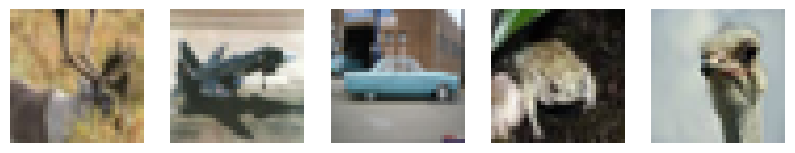

In [ ]:
# CIFAR10 preparation

# Load CIFAR-10 dataset
(x, y), (x_test, y_test) = cifar10.load_data()
from sklearn.model_selection import train_test_split
x_train, x_v, y_train, y_v = train_test_split(x, y, test_size=0.2, random_state=42)

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_val = x_v.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# load models

ResNet56v1 = load_model('../data/n_9_v1_cifar10.keras')

## FGM method

- Epsilon = 216/255
- $L_2$ norm
- Cliped within $[0,1]$
- targeted to 2nd; targeted to least; untargeted
- whole train/val/test
- ResNet56v1 (Indexed by 0 in our model data)

In [ ]:
from cleverhans.tf2.attacks import fast_gradient_method as fgm # 1-step gradient method.

## configuration
eps = 216 / 255  # 0.847
norm = 2
clip_max = 1.0
clip_min = 0.0
GENmodel = ResNet56v1
batch_size = 2500
print(f"Generating adversarial sample using FGM...")
print(f'configurations: eps={eps}, norm={norm}, clip_max={clip_max}, clip_min={clip_min}, model=ResNet56v1')
samples = {'x_train': x_train, 'x_val': x_val, 'x_test': x_test}
for sample_name, sample in samples.items():
    size = sample.shape[0]
    batch_num = size // batch_size
    print(f'From {sample_name}...')
    for i in range(batch_num):
        print(f'Processing batch {i+1}/{batch_num}...')
        batch = sample[i*batch_size:(i+1)*batch_size]
        logits_prob = GENmodel(batch, training=False)
        top2 = tf.math.top_k(logits_prob, k=2)[1]
        second_likely = top2[:, 1].numpy()
        least_likely = tf.argmin(logits_prob, axis=-1).numpy()
        for targeted in [True, False]:
            if targeted:
                print('  Targeted attack', end = ' ')
                print(' To second likely', end = ' ')
                adv_FGM = fgm.fast_gradient_method(GENmodel, 
                               batch, 
                               eps=eps, norm=norm, 
                               clip_max=clip_max, clip_min=clip_min,
                               y=second_likely, targeted=True)
                np.save(f'adversarial_examples/gen_by_ResNet/fgm_{eps}_target-to-2nd_{sample_name}_batch{i+1}.npy', adv_FGM)
                print(f'Saved to adversarial_examples/gen_by_ResNet/fgm_{eps}_target-to-2nd_{sample_name}_batch{i+1}.npy')
                print('and To least likely', end = ' ')
                adv_FGM_least = fgm.fast_gradient_method(GENmodel, 
                               batch, 
                               eps=eps, norm=norm, 
                               clip_max=clip_max, clip_min=clip_min,
                               y=least_likely, targeted=True)
                np.save(f'adversarial_examples/gen_by_ResNet/fgm_{eps}_target-to-least_{sample_name}_batch{i+1}.npy', adv_FGM)
                print(f'Saved to adversarial_examples/gen_by_ResNet/fgm_{eps}_target-to-least_{sample_name}_batch{i+1}.npy')
            else:
                print('  Untargeted attack', end = ' ')
                adv_FGM = fgm.fast_gradient_method(GENmodel, 
                               batch, 
                               eps=eps, norm=norm, 
                               clip_max=clip_max, clip_min=clip_min)
                np.save(f'adversarial_examples/gen_by_ResNet/fgm_{eps}_untargeted_{sample_name}_batch{i+1}.npy', adv_FGM)
                print(f'Saved to adversarial_examples/gen_by_ResNet/fgm_{eps}_untargeted_{sample_name}_batch{i+1}.npy')


In [ ]:
## Concatenate adversarial examples

advs_x_2nd = []
advs_x_least = []
advs_x_untargeted = []
for sample_name, sample in samples.items():
    size = sample.shape[0]
    batch_num = size // batch_size
    for i in range(batch_num):
        adv_FGM_2nd = np.load(f'adversarial_examples/gen_by_ResNet/fgm_{eps}_target-to-2nd_{sample_name}_batch{i+1}.npy')
        advs_x_2nd.append(adv_FGM_2nd)
        adv_FGM_least = np.load(f'adversarial_examples/gen_by_ResNet/fgm_{eps}_target-to-least_{sample_name}_batch{i+1}.npy')
        advs_x_least.append(adv_FGM_least)
        adv_FGM_untargeted = np.load(f'adversarial_examples/gen_by_ResNet/fgm_{eps}_untargeted_{sample_name}_batch{i+1}.npy')
        advs_x_untargeted.append(adv_FGM_untargeted)
    advs_x_2nd = np.concatenate(advs_x_2nd, axis=0)
    np.save(f'adversarial_examples/gen_by_ResNet/fgm_{eps}_target-to-2nd_{sample_name}.npy', advs_x_2nd)
    print(f'Saved FGM targeted to 2nd samples for eps={eps}')

    advs_x_least = np.concatenate(advs_x_least, axis=0)
    np.save(f'adversarial_examples/gen_by_ResNet/fgm_{eps}_target-to-least_{sample_name}.npy', advs_x_least)
    print(f'Saved FGM targeted to least samples for eps={eps}')

    advs_x_untargeted = np.concatenate(advs_x_untargeted, axis=0)
    np.save(f'adversarial_examples/gen_by_ResNet/fgm_{eps}_untargeted_{sample_name}.npy', advs_x_untargeted)
    print(f'Saved FGM untargeted samples for eps={eps}')

## DeepFool Method

In [ ]:
from cleverhans_modified.tf2.attacks import deep_fool

## configuration
clip_max = 1.0
clip_min = 0.0
GENmodel = ResNet56v1
batch_size = 2500

print(f"Generating adversarial sample using DeepFool...")
print(f'configurations: eps={eps}, norm=L2, clip_max={clip_max}, clip_min={clip_min}, model=ResNet56v1')
samples = {'x_train': x_train, 'x_val': x_val, 'x_test': x_test}
for sample_name, sample in samples.items():
    size = sample.shape[0]
    batch_num = size // batch_size
    print(f'From {sample_name}...')
    for i in range(batch_num):
        print(f'Processing batch {i+1}/{batch_num}...')
        batch = sample[i*batch_size:(i+1)*batch_size]
        print('  Untargeted attack', end = ' ')
        
        x_adv_deepfool = deep_fool.deepfool(
            GENmodel, batch,
            max_iter=50,
            nb_candidate=10,
            overshoot=0.02,
            clip_min=0.0, clip_max=1.0,
        )
        np.save(f'adversarial_examples/gen_by_ResNet/deepfool_untargeted_{sample_name}_batch{i+1}.npy', x_adv_deepfool)
        print(f'Saved to adversarial_examples/gen_by_ResNet/deepfool_untargeted_{sample_name}_batch{i+1}.npy')


In [ ]:
## Concatenate adversarial examples

advs_x= []
for sample_name, sample in samples.items():
    size = sample.shape[0]
    batch_num = size // batch_size
    for i in range(batch_num):
        adv = np.load(f'adversarial_examples/gen_by_ResNet/deepfool_untargeted_{sample_name}_batch{i+1}.npy')
        advs_x.append(adv)
    advs_x = np.concatenate(advs_x, axis=0)
    np.save(f'adversarial_examples/gen_by_ResNet/deepfool_untargeted_{sample_name}.npy', advs_x)
    print(f'Saved DeepFool samples\n')